#### Developing Custom PyTorch Dataloaders
A significant amount of the effort applied to developing machine learning algorithms is related to data preparation. PyTorch provides many tools to make data loading easy and hopefully, makes your code more readable. In this recipe, you will learn how to:
1. Create a custom dataset leveraging the PyTorch dataset APIs;
2. Create callable custom transforms that can be composable;
3. Put these components together to create a custom dataloader.

##### Face Dataset
The dataset we are going to deal with is that of facial pose. Overall, 68 different landmark points are annotated for each face.

First of all, we need to download the dataset. I have 2 ways to do this:
1. Download the dataset from the link provided. The dataset is available at [here](https://download.pytorch.org/tutorial/faces.zip). You can download it and place it in the `data` folder of this repository. The dataset contains images of faces and their corresponding landmark points.
After that, you can unzip the dataset and use it in the notebook.
2. Use the `wget` command to download the dataset directly from the notebook. This is a more convenient way to download the dataset, especially if you are using a cloud-based environment like Google Colab or Jupyter Notebook.

First, you can use command line for get the current directory and create a `data` folder if it does not exist:
``` bash
# Get current directory
pwd

# Create data folder if it does not exist
mkdir -p data
```

Next, you can use the `wget` command to download the dataset directly from the notebook. This will save you the hassle of downloading the dataset manually and placing it in the `data` folder.

``` bash
# Download the dataset using wget
wget https://download.pytorch.org/tutorial/faces.zip -P /path/to/your/data/folder

# Unzip the dataset
unzip /path/to/your/data/folder/faces.zip -d /path/to/your/data/folder

# use can unzip immediately in folder same with zip file
unzip faces.zip
```

##### Set up the environment

In [126]:
# Ignore warnings
import warnings

path_dataset = "/data/faces"
warnings.filterwarnings("ignore")

Let’s quickly read the CSV and get the annotations in an (N, 2) array where N is the number of landmarks.

In [127]:
import pandas as pd
import numpy as np

path_csv = path_dataset + "/face_landmarks.csv"
landmarks_frame = pd.read_csv(path_csv)

n = 50
img_name = landmarks_frame.iloc[n, 0]
landmarks = landmarks_frame.iloc[n, 1:]
print(landmarks.shape)

landmarks = np.asarray(landmarks)
print(landmarks.shape)

landmarks = landmarks.astype("float").reshape(-1, 2)

print(landmarks.shape)

print("Image name: {}".format(img_name))
print("Landmarks shape: {}".format(landmarks.shape))
print("First 4 Landmarks: {}".format(landmarks[:4]))

(136,)
(136,)
(68, 2)
Image name: 3689162471_5f9ffb5aa0.jpg
Landmarks shape: (68, 2)
First 4 Landmarks: [[237.  83.]
 [235.  94.]
 [233. 106.]
 [233. 118.]]


Write a simple helper function to show an image

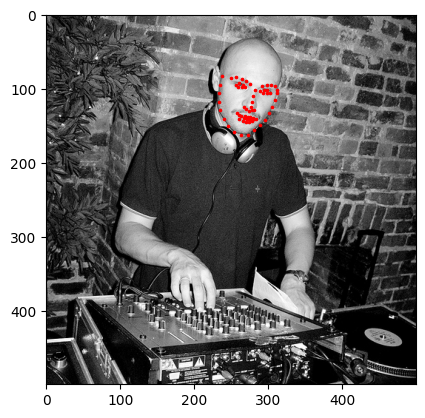

In [128]:
from skimage import io
import os
from matplotlib import pyplot as plt


def show_landmarks(img, lms):
    plt.imshow(img)  # Convert BGR to RGB
    plt.scatter(lms[:, 0], lms[:, 1], s=10, marker='.', c='r')
    plt.pause(0.001)


img_path = os.path.join(path_dataset, img_name)
image_show = io.imread(img_path)
plt.figure()
show_landmarks(image_show, landmarks)
plt.show()

Create custom dataset class

In [129]:
import torch
import pandas as pd
from torch.utils.data import Dataset


class FaceLandmarksDataset(Dataset):
    """
    Face Landmarks dataset.
    Args:
        csv (string): Path to the csv file with annotations.
        root (string): Directory with all the images.
        transform (callable, optional): Optional transform to be applied  on a sample.
    """

    def __init__(self, csv, root, transform=None):
        self.landmarks_frame = pd.read_csv(csv)
        self.root = root
        self.transform = transform

    def __len__(self):
        return len(self.landmarks_frame)

    def __getitem__(self, idx):
        """
        Args:
            idx (int or torch.Tensor): Index of the sample to be fetched.
        Returns:
            sample (dict): A dictionary containing the image and its corresponding landmarks.
            - image (numpy.ndarray): The image read from the file.
            - landmarks (numpy.ndarray): The landmarks of the face in the image, shape (68, 2).
        """
        if torch.is_tensor(idx):
            idx = idx.tolist()

        path = os.path.join(self.root, self.landmarks_frame.iloc[idx, 0])
        image = io.imread(path)

        # shape (136,)
        landmarks = self.landmarks_frame.iloc[idx, 1:]

        # shape (1, 136)
        landmarks = np.array([landmarks])

        # shape (68, 2)
        landmarks = landmarks.astype("float").reshape(-1, 2)
        sample = {"image": image, "landmarks": landmarks}

        if self.transform:
            sample = self.transform(sample)

        return sample

##### Iterate through data samples

0 (324, 215, 3) (68, 2)


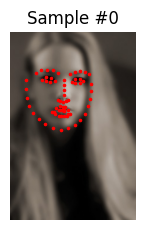

1 (500, 333, 3) (68, 2)


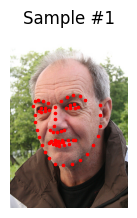

2 (250, 258, 3) (68, 2)


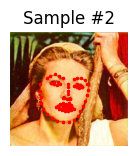

3 (434, 290, 3) (68, 2)


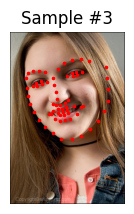

In [130]:
path_csv = path_dataset + "/face_landmarks.csv"

face_dataset = FaceLandmarksDataset(
    csv=path_csv,
    root=path_dataset,
    transform=None
)

fig = plt.figure()

for i in range(len(face_dataset)):
    sample = face_dataset[i]
    print(i, sample["image"].shape, sample["landmarks"].shape)
    ax = plt.subplot(1, 4, i + 1)
    plt.tight_layout()
    ax.set_title("Sample #{}".format(i))
    ax.axis("off")
    show_landmarks(sample["image"], sample["landmarks"])

    if i == 3:
        plt.show()
        break

##### Data Transformations

In [131]:
from skimage import io, transform


class Rescale(object):
    """Rescale the image in a sample to a given size.

    Args:
        output_size (tuple or int): Desired output size. If tuple, output is
            matched to output_size. If int, smaller of image edges is matched
            to output_size keeping aspect ratio the same.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, sample):
        image, landmarks = sample["image"], sample["landmarks"]
        h, w = image.shape[:2]
        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
            new_h, new_w = self.output_size

        new_h, new_w = int(new_h), int(new_w)
        img = transform.resize(image, (new_h, new_w))

        # h and w are swapped for landmarks because for images,
        # x and y axes are axis 1 and 0 respectively
        landmarks = landmarks * [new_w / w, new_h / h]
        return {'image': img, 'landmarks': landmarks}

In [132]:
class RandomCrop(object):
    """Crop randomly the image in a sample.

    Args:
        output_size (tuple or int): Desired output size. If int, square crop
            is made.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, sample):
        image, landmarks = sample["image"], sample["landmarks"]
        h, w = image.shape[:2]

        if isinstance(self.output_size, int):
            new_h, new_w = self.output_size, self.output_size
        else:
            new_h, new_w = self.output_size

        top = np.random.randint(0, h - new_h)
        left = np.random.randint(0, w - new_w)

        image = image[top: top + new_h, left: left + new_w]
        landmarks = landmarks - [left, top]
        return {"image": image, "landmarks": landmarks}


class ToTensor(object):
    def __call__(self, sample):
        image, landmarks = sample["image"], sample["landmarks"]

        # swap color axis because
        # numpy image: H x W x C
        # torch image: C X H X W

        image = image.transpose((2, 0, 1))
        return {
            "image": torch.from_numpy(image),
            "landmarks": torch.from_numpy(landmarks)
        }

##### Compose transforms and apply to a sample

(250, 258, 3) (68, 2)
0 (256, 264, 3) (68, 2)


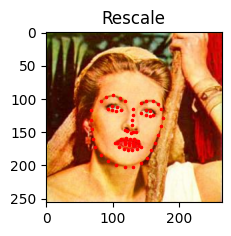

1 (128, 128, 3) (68, 2)


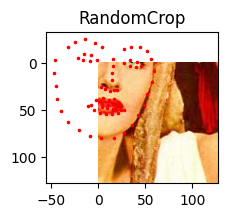

2 (224, 224, 3) (68, 2)


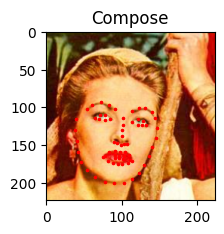

In [133]:
import torchvision.transforms as transforms

scale = Rescale(256)
crop = RandomCrop(128)

composed = transforms.Compose([Rescale(256),
                               RandomCrop(224)])

fig = plt.figure()
sample = face_dataset[2]
print(sample["image"].shape, sample["landmarks"].shape)

for i, tss in enumerate([scale, crop, composed]):
    transformed_sample = tss(sample)

    image, landmarks = transformed_sample["image"], transformed_sample["landmarks"]
    print(i, image.shape, landmarks.shape)

    ax = plt.subplot(1, 3, i + 1)
    plt.tight_layout()
    ax.set_title(type(tss).__name__)
    show_landmarks(image, landmarks)

plt.show()


##### Iterate through the dataset

In [134]:
transformed_dataset = FaceLandmarksDataset(
    csv=path_csv,
    root=path_dataset,
    transform=transforms.Compose([
        Rescale(256),
        RandomCrop(224),
        ToTensor()
    ])
)

for i in range(len(transformed_dataset)):
    sample = transformed_dataset[i]
    print(i, sample["image"].size(), sample["landmarks"].size())

    if i == 3:
        break

0 torch.Size([3, 224, 224]) torch.Size([68, 2])
1 torch.Size([3, 224, 224]) torch.Size([68, 2])
2 torch.Size([3, 224, 224]) torch.Size([68, 2])
3 torch.Size([3, 224, 224]) torch.Size([68, 2])


##### Create a DataLoader

0 torch.Size([4, 3, 224, 224]) torch.Size([4, 68, 2])
1 torch.Size([4, 3, 224, 224]) torch.Size([4, 68, 2])
2 torch.Size([4, 3, 224, 224]) torch.Size([4, 68, 2])
3 torch.Size([4, 3, 224, 224]) torch.Size([4, 68, 2])


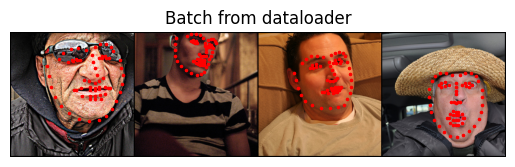

In [154]:
from torch.utils.data import DataLoader
from torchvision import utils

dataloader = DataLoader(
    transformed_dataset,
    batch_size=4,
    shuffle=True,
)


# Helper function to show a batch
def show_landmarks_batch(batched):
    """Show image with landmarks for a batch of samples."""
    images_batch, landmarks_batch = \
        batched['image'], batched['landmarks']
    batch_size = len(images_batch)
    im_size = images_batch.size(2)

    grid = utils.make_grid(images_batch)
    plt.imshow(grid.numpy().transpose((1, 2, 0)))

    for i in range(batch_size):
        plt.scatter(landmarks_batch[i, :, 0].numpy() + i * im_size,
                    landmarks_batch[i, :, 1].numpy(),
                    s=10, marker='.', c='r')

        plt.title("Batch from dataloader")


for idx, sample_batched in enumerate(dataloader):
    print(idx, sample_batched["image"].size(), sample_batched["landmarks"].size())

    # observe 4th batch and stop.
    if idx == 3:
        plt.figure()
        show_landmarks_batch(sample_batched)
        plt.axis('off')
        plt.ioff()
        plt.show()
        break